# 21.1 — Random Failure Modeling Using Weibull Inputs (Monte Carlo)

This notebook is designed to run cleanly in **Google Colab**.

## What you’ll do
1. (Optional) Fit a Weibull model (β, η) from the CLEAR-enhanced dataset  
2. Run Monte Carlo simulation to estimate failure risk over a time horizon  
3. Visualize:
   - Distribution of failure counts within the horizon  
   - Probability of ≥1 failure  
   - Percentile-based planning numbers (P50/P90/P95)

> Dataset (optional): `Failure_Events_CLEAR_Enhanced.xlsx`  
If you skip dataset fitting, you can input β and η manually.


## 0) Install dependencies (Colab)

In [3]:
# If running in Google Colab, uncomment and run once:
!pip install "numpy<2.0"
!pip -q install reliability openpyxl

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.2/257.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 93.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.2 which is incompatible.


## 1) Upload dataset (optional, Colab)

In [1]:
# If you want to fit β and η from the dataset, upload it here:
from google.colab import files
uploaded = files.upload()

Saving Failure_Events_CLEAR_Enhanced.xlsx to Failure_Events_CLEAR_Enhanced.xlsx


## 2) Imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from reliability.Fitters import Fit_Weibull_2P

## 3) Choose how to get Weibull parameters (β, η)

Two options:

### Option A — Fit from dataset
Derive **time-between-failure intervals** per asset and fit Weibull(β, η).

### Option B — Manual input
Enter β and η directly if you already have them.

Set `USE_DATASET_FIT = True` for Option A, otherwise `False`.


In [5]:
USE_DATASET_FIT = True  # True = fit from Excel; False = manual input

# Manual Weibull parameters (used if USE_DATASET_FIT = False)
BETA_MANUAL = 1.22
ETA_MANUAL  = 5910.9  # hours

## 4) Get Weibull parameters

In [6]:
DATA_FILE = "Failure_Events_CLEAR_Enhanced.xlsx"

if USE_DATASET_FIT:
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(
            f"{DATA_FILE} not found. Upload it first (Section 1) or set USE_DATASET_FIT = False."
        )

    df = pd.read_excel(DATA_FILE)

    required_cols = ["Asset_ID", "Event_Type", "Failure_Start"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df["Failure_Start"] = pd.to_datetime(df["Failure_Start"], errors="coerce")
    df = df.dropna(subset=["Failure_Start"]).copy()

    FAILURE_EVENTS = {"FAILURE", "TRIP"}  # edit if needed

    df_fail = df[df["Event_Type"].astype(str).str.upper().isin(FAILURE_EVENTS)].copy()
    df_fail["Event_Type"] = df_fail["Event_Type"].astype(str).str.upper()

    df_fail = df_fail.sort_values(["Asset_ID", "Failure_Start"])
    df_fail["TTF_hours"] = df_fail.groupby("Asset_ID")["Failure_Start"].diff().dt.total_seconds() / 3600.0

    intervals = df_fail["TTF_hours"].dropna()
    intervals = intervals[intervals > 0]

    print("Derived failure intervals (hours):", len(intervals))

    # Simple right-censoring (recommended)
    OBS_END = df["Failure_Start"].max()
    last_fail = df_fail.groupby("Asset_ID")["Failure_Start"].max()
    right_censored = (OBS_END - last_fail).dt.total_seconds() / 3600.0
    right_censored = right_censored[right_censored > 0]

    fit = Fit_Weibull_2P(
        failures=intervals.values,
        right_censored=right_censored.values,
        show_probability_plot=False
    )

    beta = float(fit.beta)
    eta  = float(fit.alpha)

    print(f"Fitted β (shape): {beta:.4f}")
    print(f"Fitted η (scale): {eta:.2f} hours")
else:
    beta = float(BETA_MANUAL)
    eta  = float(ETA_MANUAL)
    print(f"Manual β (shape): {beta:.4f}")
    print(f"Manual η (scale): {eta:.2f} hours")

Derived failure intervals (hours): 113
Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 113/48 (29.81366% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         7977.34         628.256   6836.31   9308.82
     Beta         1.19621        0.088274   1.03512   1.38236 

Goodness of fit    Value
 Log-likelihood -1125.26
           AICc  2254.59
            BIC  2260.67
             AD  5.04371 

Fitted β (shape): 1.1962
Fitted η (scale): 7977.34 hours


## 5) Monte Carlo model definition

We model random **time-to-first-failure** within the horizon using Weibull(β, η).

For each simulation run:
1. Sample one failure time for each operating unit (fleet size = `N_UNITS`)
2. Count how many failures occur within `T_HORIZON`
3. Store the failure count

> Repairable system simulation (multiple failures + repair downtime) is covered in Section 21.2.


In [7]:
# === EDIT THESE FOR YOUR SCENARIO ===
N_UNITS    = 10       # number of identical units operating (fleet size)
T_HORIZON  = 3000.0   # hours (planning horizon)
N_SIM      = 20000    # Monte Carlo iterations
SEED       = 42       # reproducibility

## 6) Run Monte Carlo simulation

In [8]:
rng = np.random.default_rng(SEED)

failure_counts = np.empty(N_SIM, dtype=int)

# Weibull sampling:
# numpy's rng.weibull(beta) returns Weibull(shape=beta, scale=1)
# multiply by eta to apply the scale
for i in range(N_SIM):
    ttf = eta * rng.weibull(beta, size=N_UNITS)  # hours
    failure_counts[i] = int(np.sum(ttf <= T_HORIZON))

failure_counts[:20], float(failure_counts.mean())

(array([3, 3, 3, 2, 3, 4, 1, 1, 5, 4, 1, 4, 4, 2, 2, 2, 2, 3, 1, 4]), 2.67915)

## 7) Summarize risk metrics

In [9]:
mean_fail = float(np.mean(failure_counts))
p_ge1 = float(np.mean(failure_counts >= 1))
p_ge2 = float(np.mean(failure_counts >= 2))

p50 = float(np.percentile(failure_counts, 50))
p90 = float(np.percentile(failure_counts, 90))
p95 = float(np.percentile(failure_counts, 95))
p99 = float(np.percentile(failure_counts, 99))

print(f"Weibull inputs: β={beta:.3f}, η={eta:.1f} hours")
print(f"Scenario: N_UNITS={N_UNITS}, T_HORIZON={T_HORIZON:.0f} hours, N_SIM={N_SIM}")
print()
print(f"Expected failures within horizon (mean): {mean_fail:.3f}")
print(f"P(failures ≥ 1): {p_ge1:.3f}")
print(f"P(failures ≥ 2): {p_ge2:.3f}")
print()
print(f"Failure count percentiles: P50={p50:.0f}, P90={p90:.0f}, P95={p95:.0f}, P99={p99:.0f}")

Weibull inputs: β=1.196, η=7977.3 hours
Scenario: N_UNITS=10, T_HORIZON=3000 hours, N_SIM=20000

Expected failures within horizon (mean): 2.679
P(failures ≥ 1): 0.955
P(failures ≥ 2): 0.791

Failure count percentiles: P50=3, P90=5, P95=5, P99=6


## 8) Plot: Failure-count distribution

The histogram shows how many failures you should plan for within the horizon — including high-percentile risk.


Saved: figures/MC_21_1_failure_count_hist.png


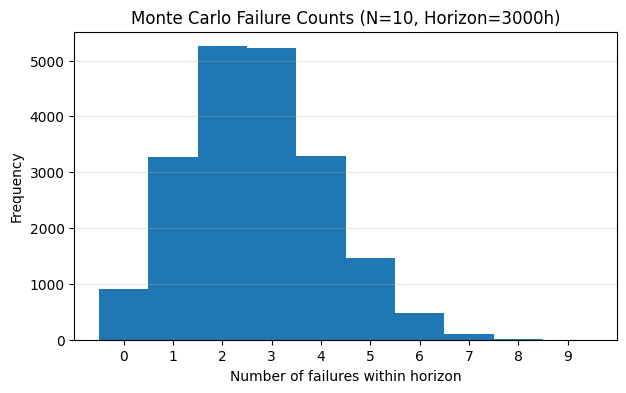

In [10]:
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

bins = np.arange(failure_counts.min(), failure_counts.max() + 2) - 0.5

plt.figure(figsize=(7,4))
plt.hist(failure_counts, bins=bins)
plt.xticks(range(int(failure_counts.min()), int(failure_counts.max()) + 1))
plt.xlabel("Number of failures within horizon")
plt.ylabel("Frequency")
plt.title(f"Monte Carlo Failure Counts (N={N_UNITS}, Horizon={T_HORIZON:.0f}h)")
plt.grid(True, axis="y", alpha=0.3)

out = os.path.join(FIG_DIR, "MC_21_1_failure_count_hist.png")
plt.savefig(out, dpi=300, bbox_inches="tight")
print("Saved:", out)
plt.show()

## 9) Plot: Cumulative risk curve P(Failures ≥ k)

This figure is useful for planning spares and manpower:
- “How likely is it that we see at least k failures within the horizon?”


Saved: figures/MC_21_1_cumulative_risk_curve.png


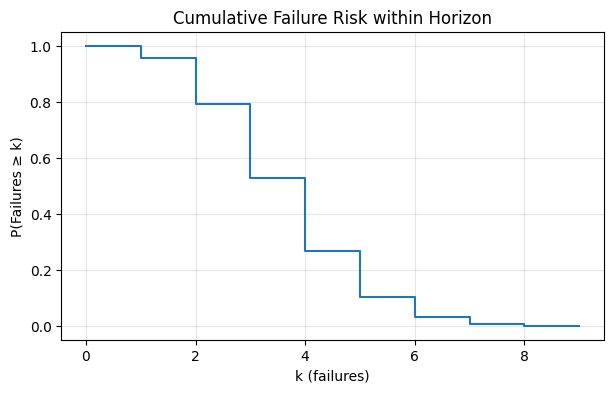

In [11]:
max_k = int(failure_counts.max())
ks = np.arange(0, max_k + 1)
p_ge_k = np.array([np.mean(failure_counts >= k) for k in ks])

plt.figure(figsize=(7,4))
plt.step(ks, p_ge_k, where="post")
plt.xlabel("k (failures)")
plt.ylabel("P(Failures ≥ k)")
plt.title("Cumulative Failure Risk within Horizon")
plt.grid(True, alpha=0.3)

out = os.path.join(FIG_DIR, "MC_21_1_cumulative_risk_curve.png")
plt.savefig(out, dpi=300, bbox_inches="tight")
print("Saved:", out)
plt.show()

## 10) Copy-ready interpretation template (for your manuscript)

In [ ]:
print(
f"""Copy-ready interpretation (edit numbers as needed):

Using Weibull inputs (β={beta:.3f}, η={eta:.1f} hours), we simulated {N_SIM} Monte Carlo futures for a fleet of {N_UNITS} identical units
over a planning horizon of {T_HORIZON:.0f} hours.

The expected number of failures within the horizon is {mean_fail:.2f}. The probability of experiencing at least one failure is {p_ge1:.2%},
and the probability of experiencing at least two failures is {p_ge2:.2%}. The distribution of outcomes is right-skewed, with failure-count
percentiles P50={p50:.0f}, P90={p90:.0f}, and P95={p95:.0f}.

These results quantify both the expected maintenance workload and the high-percentile risk that drives contingency planning
for spares and maintenance resources.

Figures: MC_21_1_failure_count_hist.png, MC_21_1_cumulative_risk_curve.png
"""
)

## 11) (Colab) Download figures (optional)

In [ ]:
# Uncomment in Colab:
# import shutil
# from google.colab import files
# shutil.make_archive("MC_21_1_figures", "zip", "figures")
# files.download("MC_21_1_figures.zip")